In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import os
import torch

from torch.utils.data import DataLoader
from torch import nn
from model import TilePredNet
from dataset import TileDataset
from utils.metrics import get_metrics
cwd = os.getcwd()

In [2]:
train_df = pd.read_csv(r"C:\Users\agent\OneDrive\UM\project_2_1\rummicubei\data\training_data\train_baseline_vs_baseline_data.csv")
test_df = pd.read_csv(r"C:\Users\agent\OneDrive\UM\project_2_1\rummicubei\data\training_data\test_baseline_vs_baseline_data.csv")
metrics = pd.read_csv(r"C:\Users\agent\OneDrive\UM\project_2_1\rummicubei\machine_learning\model_files\20240122-09_05_14_metrics_epochs_40_batchSize1_l0.0005_loss_CrossEntropyLoss_opt_type.csv", header=1)

<Axes: xlabel='epoch', ylabel='loss'>

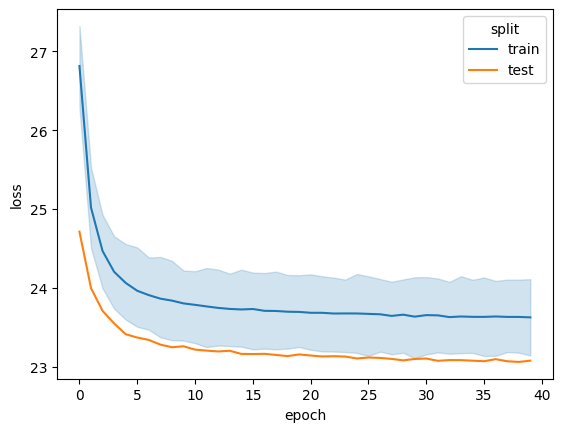

In [3]:
sns.lineplot(data=metrics, x="epoch", y="loss", hue="split") # shows the 95% confidence intervall

<Axes: xlabel='epoch', ylabel='accuracy'>

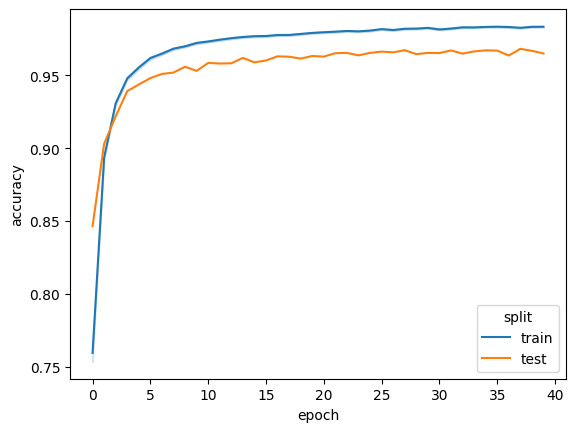

In [4]:
sns.lineplot(data=metrics, x="epoch", y="accuracy", hue="split")

<Axes: xlabel='epoch', ylabel='F1Scores'>

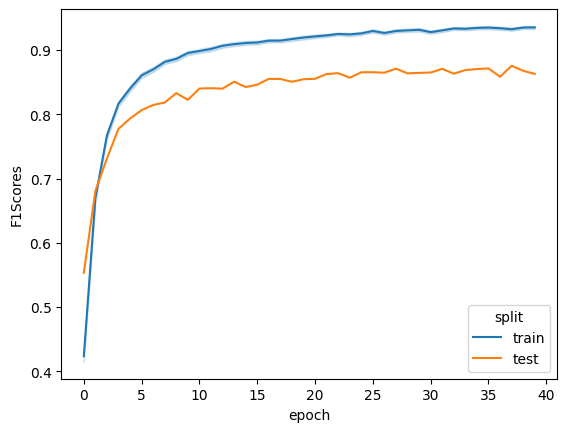

In [5]:
sns.lineplot(data=metrics, x="epoch", y="F1Scores", hue="split")

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [7]:
MODEL_PATH = r"C:\Users\agent\OneDrive\UM\project_2_1\rummicubei\machine_learning\model_files\20240122-09_05_14_model_epochs_39_batch_size1_l_0.0005_loss_CrossEntropyLoss_opt_type.pt"
model = TilePredNet(n_rounds=8, n_out=53, n_sets=679, dropout=0.2)
model.load_state_dict(torch.load(MODEL_PATH, map_location=torch.device(device)))
model.to(device)

TilePredNet(
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batch_norm1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sigmoid): Sigmoid()
  (fc_in): Linear(in_features=5485, out_features=679, bias=True)
  (fc_hidden_1): Linear(in_features=679, out_features=1000, bias=True)
  (fc_out): Linear(in_features=1000, out_features=53, bias=True)
)

In [8]:
train_path = r"C:\Users\agent\OneDrive\UM\project_2_1\rummicubei\data\training_data\train_baseline_vs_baseline_data.csv"
test_path = r"C:\Users\agent\OneDrive\UM\project_2_1\rummicubei\data\training_data\test_baseline_vs_baseline_data.csv"
train_dataset = TileDataset(annotations_file=train_path, device=device)
test_dataset = TileDataset(annotations_file=test_path, device=device)

print("Train:", len(train_dataset))
print("test", len(test_dataset))

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

Train: 4008
test 1719


In [14]:
loss_fn = nn.CrossEntropyLoss()
train_preds = []
train_target = []
train_loss = []
for X, y in train_dataloader:
    with torch.no_grad():
        train_preds.append(model(X))
        train_target.append(y)
        train_loss.append(loss_fn(train_preds[-1],y))

test_preds = []
test_target = []
test_loss = []
for X, y in test_dataloader:
    with torch.no_grad():
        test_preds.append(model(X))
        test_target.append(y)
        test_loss.append(loss_fn(test_preds[-1],y))

In [15]:
get_metrics(torch.concat(train_preds), torch.concat(train_target))

{'acc': 0.9839142560958862,
 'mcc': 0.9316114187240601,
 'precision': 0.9359989166259766,
 'recall': 0.9458604454994202,
 'specificity': 0.9898728728294373,
 'f1': 0.9409038424491882,
 'dice': 0.9409038424491882}

In [16]:
get_metrics(torch.concat(test_preds), torch.concat(test_target))

{'acc': 0.9662155508995056,
 'mcc': 0.8546759486198425,
 'precision': 0.8525599837303162,
 'recall': 0.896148681640625,
 'specificity': 0.9767342209815979,
 'f1': 0.8738110661506653,
 'dice': 0.8738110661506653}

In [17]:
print("Train loss:", np.mean(train_loss))
print("Test loss:", np.mean(test_loss))

Train loss: 23.61727
Test loss: 23.08581
